In [1]:
import GPy, numpy as np, pandas as pd
from GPy.kern import LinearSlopeBasisFuncKernel, DomainKernel, ChangePointBasisFuncKernel
%matplotlib inline
from matplotlib import pyplot as plt

Parametric model alongside non-Parametric model
===================

Suppose unlike with a standard Gaussian process, where you believe there is a single latent process which models some parameter of interest (usually the mean of a likelihood distribution), your belief about the underlying process is that it is composed of a number of processes. 

A common way to handle this with Gaussian processes is to simply build a kernel that is a composition of several kernels. Typically the kernels are used to encode different assumptions about the data itself, for example one kernel may work on changes on a seasonal scale and another kernel may encode short term changes. By using standard kernels we are still proposing that the individual functions are non-parametric in nature - that is the number of basis functions is potentially infinite and grows with the number of observations.

In this notebook we will explore a technique whereby we can introduce fixed basis function kernels that represent parametric functions, rather than the standard non-parametric function of a Gaussian process. In this case the number of basis functions of the kernel does *not* grow with the number of datapoints.

A great background talk that shows the the relationship between Gaussian process models and fixed basis function kernels can be found here: https://www.youtube.com/watch?v=C9ZnpFG69KE

The underlying generative model for the model we are going to introduce throughout the rest of this notebook is a *sum* of non-parametric functions and parametric functions.

Let us consider a few examples of what kind of data can be analysed using these compositions of parametric and non-parametric functions. 

For the parametric function component we could consider step functions, in this case the function will be composed of steps, in between which the function values are constant:

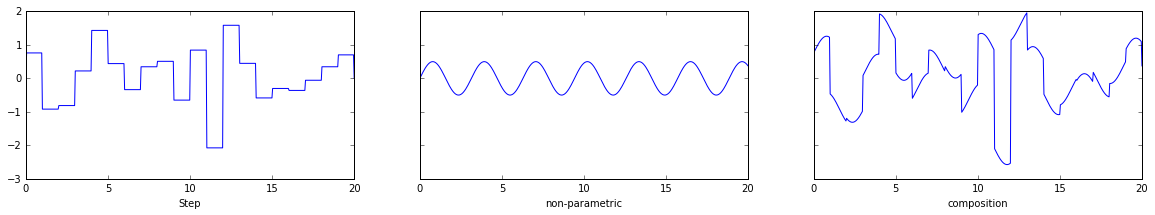

In [13]:
X = np.linspace(0,20, 500)[:, None]
num_steps = 20
step_starts = np.arange(0, num_steps)
step_stops = step_starts+1
phi = np.where((X>step_starts)*(X<step_stops), 1, 0) # makes a design matrix representing the steps 
parametric_weights = np.random.randn(num_steps)[:, None]

step_function = phi.dot(parametric_weights)
non_parametric = 0.5*np.sin(2*X)
full_function = step_function + non_parametric

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,3), sharey=True)
ax1.plot(X, step_function, label='Step')
ax1.set_xlabel('Step')
ax2.plot(X, non_parametric, label='non-parametric')
ax2.set_xlabel('non-parametric')
ax3.plot(X, full_function, label='composition')
ax3.set_xlabel('composition')


Note here the step functions 

The nomenclature throughout the rest of this tutorial is shared with the notation used in [BayesianLinearRegression](../background/BayesianLinearRegression.ipynb). For example $\mathbf{\Phi}$ is the design matrix, which might be composed of either infinite or fixed basis functions.  We can perform inference for both the parametric and non-parametric components by extending the existing methodology of Gaussian processes whereby the design matrix contains fixed and non-fixed basis function features, $\Phi$. The marginal likelihood is computed as usual,

\begin{align}
p(\mathbf{y}|\boldsymbol{\Phi}, \alpha, \sigma) &= \int p(\mathbf{y}|\boldsymbol{\Phi}, \mathbf{w}, \sigma)p(\mathbf{w}|\alpha) \,\mathrm{d}\mathbf{w}\\
&= \langle\mathcal{N}(\mathbf{y}|\boldsymbol{\Phi}\mathbf{w}, \sigma^2\mathbf{I})\rangle_{\mathcal{N}(\mathbf{0}, \alpha\mathbf{I})}\\
&= \mathcal{N}(\mathbf{y}|\mathbf{0}, \alpha\boldsymbol{\Phi}\boldsymbol{\Phi}^\top + \sigma^2\mathbf{I})\enspace.
\end{align}

Thus, we can maximize this marginal likelihood w.r.t. the hyperparameters $\alpha, \sigma$ by log transforming and maximizing:

\begin{align}
\hat\alpha, \hat\sigma = \mathop{\arg\max}_{\alpha, \sigma}\log p(\mathbf{y}|\boldsymbol{\Phi}, \alpha, \sigma)
\end{align}

So we will define a mixed inference model mixing parametric and non-parametric models together. One part is described by a paramtric feature space mapping $\boldsymbol{\Phi}\mathbf{w}$ and the other part is a non-parametric function $\mathbf{f}_\text{n}$. For this we define the underlying function $\mathbf{f}$ as 

$$
\begin{align}
p(\mathbf{f}) &= p\left(
  \underbrace{
  \begin{bmatrix} 
   \delta(t-T)\\
   \boldsymbol{\Phi}
  \end{bmatrix}
  }_{=:\mathbf{A}}
  \left.
  \begin{bmatrix}
   \mathbf{f}_{\text{n}}\\
   \mathbf{w}
  \end{bmatrix}
  \right|
  \mathbf{0}, 
  \mathbf{A}
  \underbrace{
  \begin{bmatrix}
   \mathbf{K}_{\mathbf{f}} & \\
   & \mathbf{K}_{\mathbf{w}}
  \end{bmatrix}
  }_{=:\boldsymbol{\Sigma}}
  \mathbf{A}^\top
  \right)\enspace,
\end{align}
$$

where $\mathbf{K}_{\mathbf{f}}$ is the covariance describing the non-parametric part $\mathbf{f}_\text{n}\sim\mathcal{N}(\mathbf{0}, \mathbf{K}_\mathbf{f})$ and $\mathbf{K}_{\mathbf{w}}$ is the covariance of the prior over $\mathbf{w}\sim\mathcal{N}(\mathbf{w}|\mathbf{0}, \mathbf{K}_{\mathbf{w}})$.

Thus we can now predict the different parts and even the paramters $\mathbf{w}$ themselves using (Note: If someone is willing to write down the proper path to this, here a welcome and thank you very much. Thanks to Philipp Hennig for his ideas in this.)

$$
\begin{align}
p(\mathbf{f}|\mathbf{y}) &= 
 \mathcal{N}(\mathbf{f} | 
 \boldsymbol{\Sigma}\mathbf{A}^\top 
  \underbrace{
   (\mathbf{A}\boldsymbol{\Sigma}\mathbf{A}^\top + \sigma^2\mathbf{I})^{-1}}_{=:\mathbf{K}^{-1}}\mathbf{y}, \boldsymbol{\Sigma}-\boldsymbol{\Sigma}\mathbf{A}^\top\mathbf{K}^{-1}\mathbf{A}\boldsymbol{\Sigma})
 \\
p(\mathbf{w}|\mathbf{y}) &= \mathcal{N}(\mathbf{w} | \mathbf{K}_\mathbf{w}\boldsymbol{\Phi}^\top\mathbf{K}^{-1}\mathbf{y},
\mathbf{K}_{\mathbf{w}}-\mathbf{K}_{\mathbf{w}}\boldsymbol{\Phi}^\top\mathbf{K}^{-1}\boldsymbol{\Phi}\mathbf{K}_{\mathbf{w}}))
 \\
p(\mathbf{f}_\text{n}|\mathbf{y}) &= \mathcal{N}(\mathbf{f}_\text{n}| \mathbf{K}_\mathbf{f}\mathbf{K}^{-1}\mathbf{y},
\mathbf{K}_{\mathbf{f}}-\mathbf{K}_{\mathbf{f}}\mathbf{K}^{-1}\mathbf{K}_{\mathbf{f}}))
\end{align}
$$

We will create some data with a non-linear function, strongly driven by piecewise linear trends:

In [2]:
np.random.seed(12345)

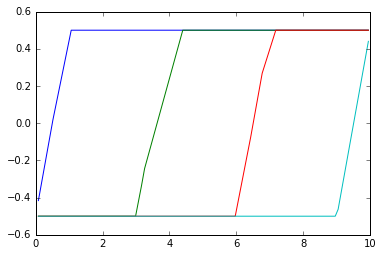

In [3]:
x = np.random.uniform(0, 10, 40)[:,None]
x.sort(0)
starts, stops = np.arange(0, 10, 3), np.arange(1, 11, 3)

k_lin = LinearSlopeBasisFuncKernel(1, starts, stops, variance=1., ARD=1)
Phi = k_lin.phi(x)
_ = plt.plot(x, Phi)

We will assume the prior over $w_i\sim\mathcal{N}(0, 3)$ and a Matern32 structure in the non-parametric part. Additionally, we add a half parametric part, which is a periodic effect only active between $x\in[3,8]$:

In [4]:
k = GPy.kern.Matern32(1, .3)
Kf = k.K(x)

k_per = GPy.kern.PeriodicMatern32(1, variance=100, period=1)
k_per.period.fix()
k_dom = DomainKernel(1, 1., 5.)
k_perdom = k_per * k_dom
Kpd = k_perdom.K(x)

In [5]:
np.random.seed(1234)
alpha = np.random.gamma(3, 1, Phi.shape[1])
w = np.random.normal(0, alpha)[:,None]

f_SE = np.random.multivariate_normal(np.zeros(x.shape[0]), Kf)[:, None]
f_perdom = np.random.multivariate_normal(np.zeros(x.shape[0]), Kpd)[:, None]
f_w = Phi.dot(w)

f = f_SE + f_w + f_perdom

y = f + np.random.normal(0, .1, f.shape)

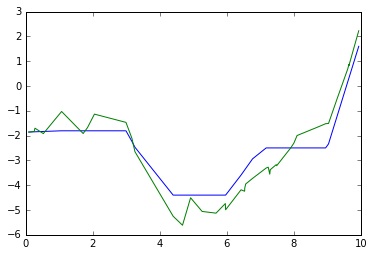

In [9]:
plt.plot(x, f_w, 'b')
_ = plt.plot(x, y, 'g')
# Make sure the function is driven by the linear trend, as there can be a difficulty in identifiability.

With this data, we can fit a model using the basis functions as paramtric part. If you want to implement your own basis function kernel, see GPy.kern._src.basis_funcs.BasisFuncKernel and implement the necessary parts. Usually it is enough to implement the phi(X) method, returning the higher dimensional mapping of inputs X.

In [7]:
k = (GPy.kern.Bias(1) 
     + GPy.kern.Matern52(1) 
     + LinearSlopeBasisFuncKernel(1, ARD=1, start=starts, stop=stops, variance=.1, name='linear_slopes')
     + k_perdom.copy()
    )

k.randomize()
m = GPy.models.GPRegression(x, y, k)

In [8]:
m.checkgrad()

True

In [9]:
m.optimize()

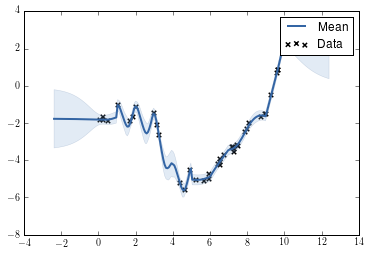

In [10]:
m.plot()

In [11]:
x_pred = np.linspace(0, 10, 500)[:,None]
pred_SE, var_SE = m._raw_predict(x_pred, kern=m.kern.Mat52)
pred_per, var_per = m._raw_predict(x_pred, kern=m.kern.mul)
pred_bias, var_bias = m._raw_predict(x_pred, kern=m.kern.bias)
pred_lin, var_lin = m._raw_predict(x_pred, kern=m.kern.linear_slopes)

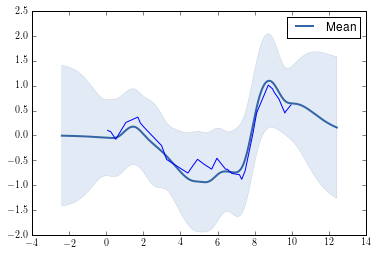

In [12]:
m.plot_f(resolution=500, predict_kw=dict(kern=m.kern.Mat52), plot_data=False)
plt.plot(x, f_SE)

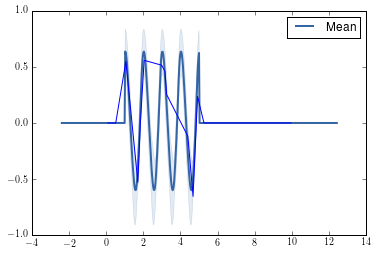

In [13]:
m.plot_f(resolution=500, predict_kw=dict(kern=m.kern.mul), plot_data=False)
plt.plot(x, f_perdom)

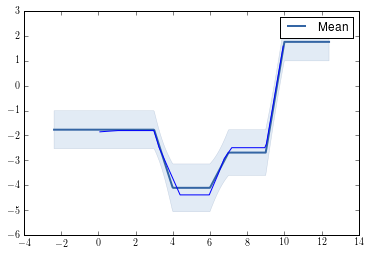

In [14]:
m.plot_f(resolution=500, predict_kw=dict(kern=m.kern.linear_slopes), plot_data=False)
plt.plot(x, f_w)

In [15]:
w_pred, w_var = m.kern.linear_slopes.posterior_inf()

In [16]:
df = pd.DataFrame(w, columns=['truth'], index=np.arange(Phi.shape[1]))
df['mean'] = w_pred
df['std'] = np.sqrt(w_var.diagonal())

In [17]:
np.round(df, 2)

,truth,mean,std
0,0.06,0.00,0.00
1,-2.59,-2.34,0.63
2,1.90,1.42,0.51
3,4.36,4.46,0.51
